In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_pinball_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
import xarray as xr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [19]:
data = pd.read_csv("solar_table.csv")

In [20]:
data.head()

,Unnamed: 0,ref_datetime,valid_datetime,SolarDownwardRadiation,Temperature,CloudCover,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,Wind_MWh_credit,Solar_MWh_credit
0,0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,0.0,13.646173,0.450405,2020-09-20 00:00:00+00:00,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17,498.142,0.0
1,1,2020-09-20 00:00:00+00:00,2020-09-20 00:30:00+00:00,0.0,13.658508,0.472211,2020-09-20 00:30:00+00:00,19.77,0.0,2108.489754,2206.064655,957.576,15.00,0.0,32.17,478.788,0.0
2,2,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,0.0,13.670843,0.494018,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00,470.522,0.0
3,3,2020-09-20 00:00:00+00:00,2020-09-20 01:30:00+00:00,0.0,13.732101,0.520214,2020-09-20 01:30:00+00:00,28.97,0.0,2108.489754,2206.064655,964.366,29.13,0.0,32.00,482.183,0.0
4,4,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,0.0,13.793360,0.546410,2020-09-20 02:00:00+00:00,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99,459.216,0.0


In [21]:
data.isna().sum()

Unnamed: 0                        0
ref_datetime                      0
valid_datetime                    0
SolarDownwardRadiation            0
Temperature                       0
CloudCover                        0
dtm                               0
MIP                            2634
Solar_MW                        545
Solar_capacity_mwp                0
Solar_installedcapacity_mwp       0
Wind_MW                         861
SS_Price                          0
boa_MWh                         861
DA_Price                          0
Wind_MWh_credit                 861
Solar_MWh_credit                545
dtype: int64

# Missing value repartition  
Through these plots, we can observe that there are "batches" of missing values which are spread randomly, maybe we should consider those batches independantly.  
Also we can see that **Wind_MW** and **boa_MWh** have the same missing values.

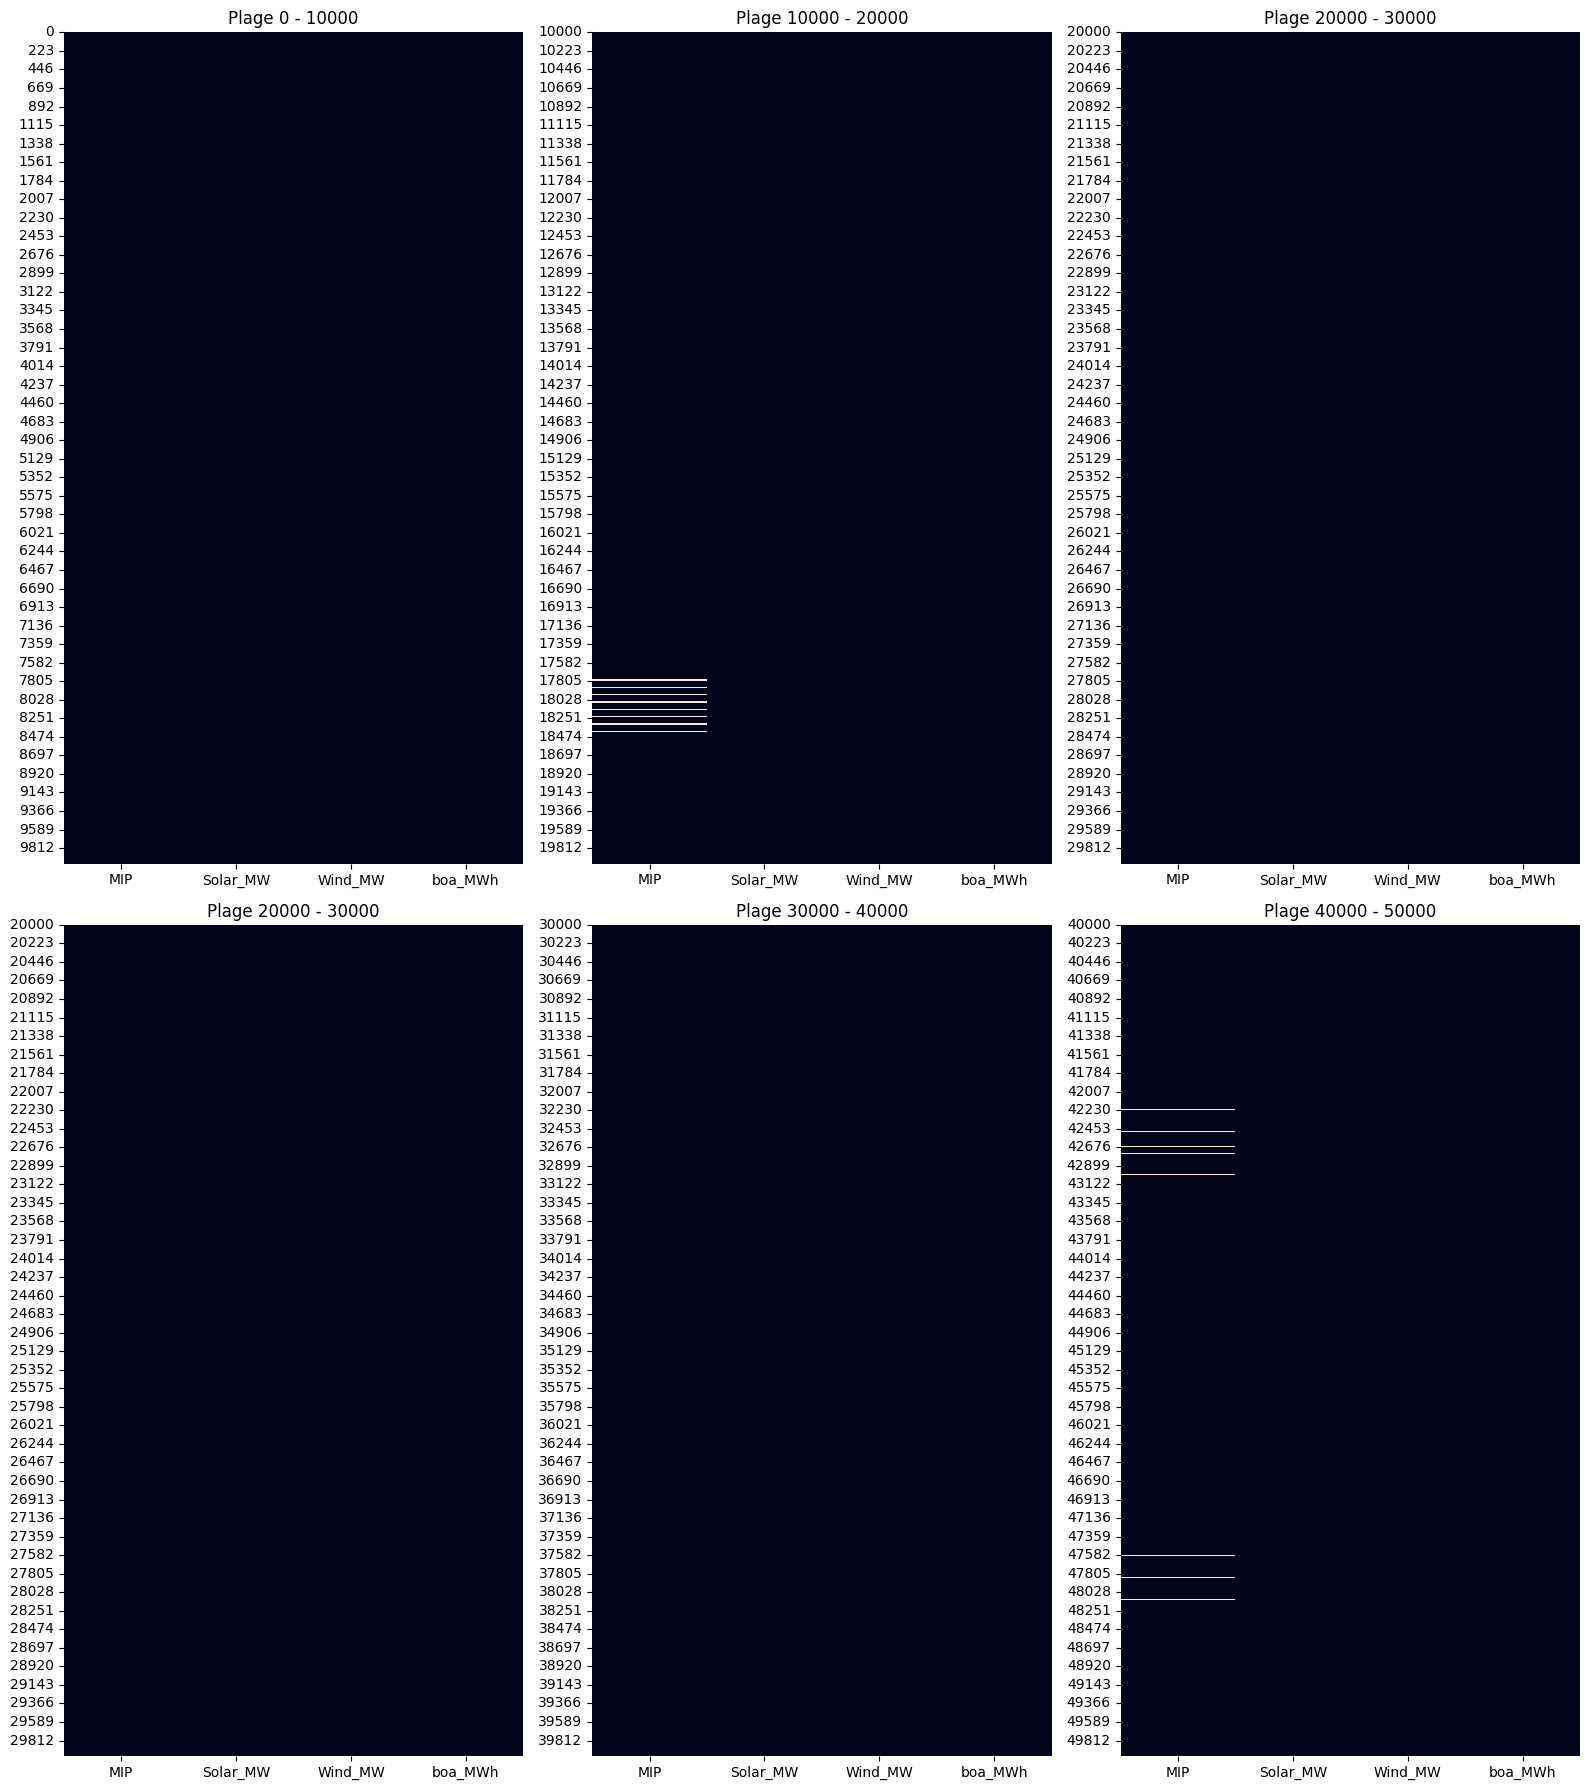

In [22]:
# # Big figures
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 50))

# Small figures
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 18))

missing_col = ["MIP", "Solar_MW", "Wind_MW", "boa_MWh"]

for i, ax_row in enumerate(axes):
    for j, ax_col in enumerate(ax_row):
        start = 10000 * (i*2 + j)
        end = 10000 * (i*2 + j + 1)
        
        if end > len(data):
            end = len(data)
        
        sns.heatmap(data[missing_col].iloc[start:end].isnull(), cbar=False, ax=ax_col)
        ax_col.set_title(f'Plage {start} - {end}')

plt.tight_layout()
plt.show()


# Outliers 

## Visualisation  

As we can see on these charts, most of the columns have a skewed gaussian (mean is different from median)

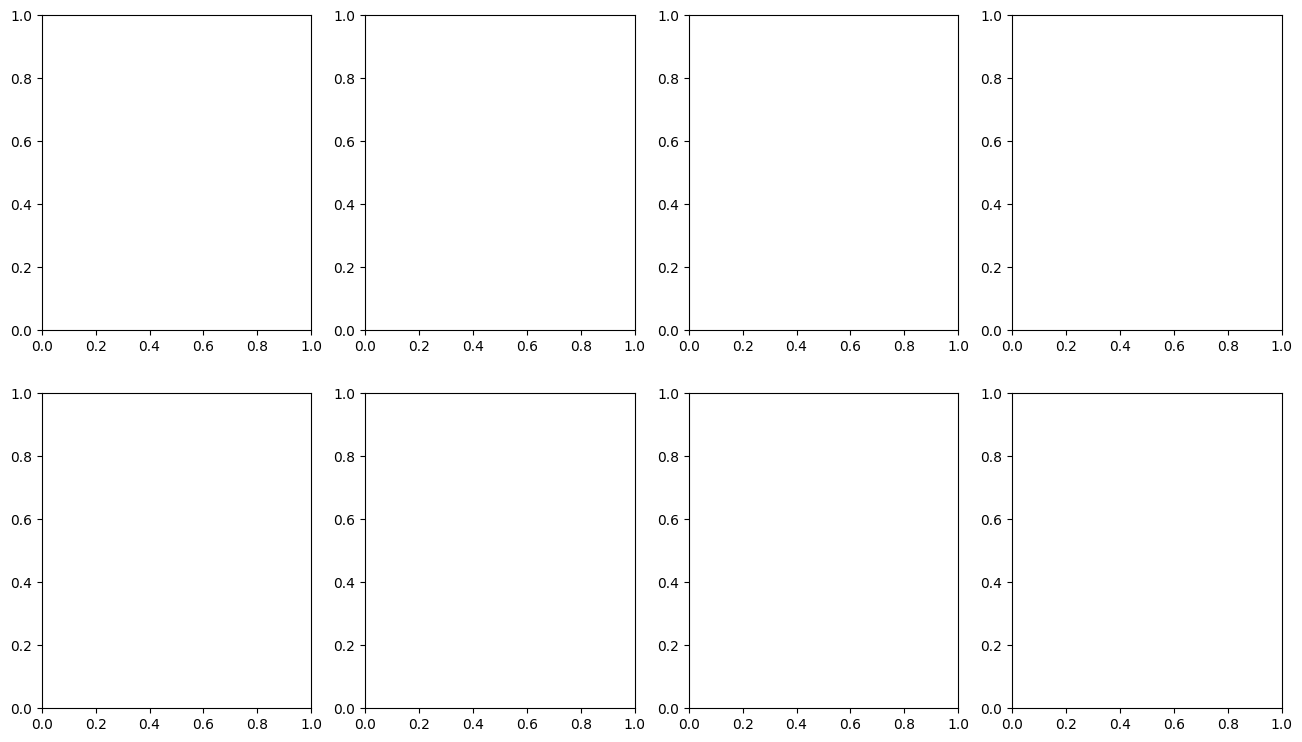

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))

#for i,col in enumerate(data.columns[1:]) : 
#    data[col].plot(kind='hist', ax=axes.flat[i])
 #   axes.flat[i].set_title(col)

  #  print(f"{col:.<30} : Mean {data[col].mean():.<10.2f} vs Median {data[col].median():.<10.2f} std = {data[col].std():.<10.2f}")

<Axes: >

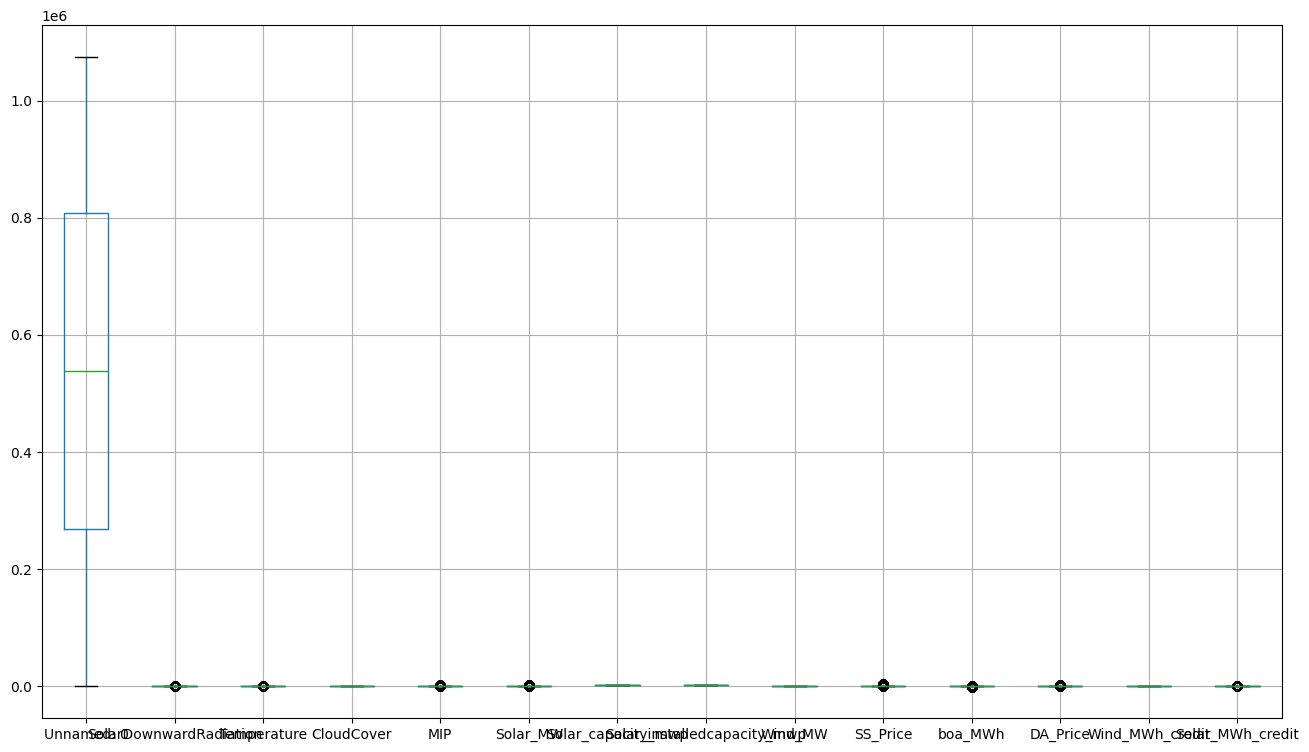

In [24]:
fig, ax = plt.subplots(figsize=(16, 9))

data.boxplot()

On peut voir que les données manquantes ne sont pas réparties aléatoirement, en effet, elles se regroupent par paquets plus ou moins grand  
On remarque aussi que les variables Wind_MW et boa_MWh on les mêmes données manquantes  

## Remove outliers  
If we remove outliers, we lose ~25% of our dataset

In [25]:
# TODO différents niveaux de 
def remove_outliers(df: pd.DataFrame, col: str):
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    
    IQR = Q3 - Q1
    upper = Q3 + IQR * 1.5 + 0.001 # boa_MWh have 0 as Q1 and Q3 
    lower = Q1 - IQR * 1.5 - 0.001
    # print(f"{col} : {lower}-{upper}")
    res = df[ (df[col] < upper) & (df[col] > lower) ]
    return res

In [26]:
data = pd.read_csv("solar_table.csv")
file_name = "energy"
if input("Remove outliers ? Y/N").lower() == "y":
    print(f"before : {data.shape}")
    file_name += "_no_outliers"
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        data = remove_outliers(data, col)
    print(f"after : {data.shape}")


# Drop missing values

# Average Fill
```energy_avgfill.csv```

In [27]:
def avg_fill(df: pd.DataFrame, col : str):
    avg = df[col].mean()
    
    df[col] = df[col].fillna(avg, inplace=False)
    return df

# Hot-deck imputation (KNN imputation)

In [28]:
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings("ignore")

def hot_deck_imputation(df: pd.DataFrame):
    models = {}
    non_missing_list = {}
    missing_rows = pd.DataFrame(df[df.isna().any(axis=1)].drop(columns=["dtm"]))
    for col in missing_col:
        data = df.drop(columns=["dtm"], inplace=False)
        non_missing_rows = data.dropna()
        non_missing_rows = non_missing_rows.drop(columns=[col], inplace=False)
        knn_model = NearestNeighbors(n_neighbors=1)
        knn_model.fit(non_missing_rows)
        models[col] = knn_model
        non_missing_list[col] = non_missing_rows

    data = df.drop(columns=["dtm"], inplace=False)
    non_missing_rows = data.dropna()
    non_missing_rows = non_missing_rows.drop(columns=["Wind_MW", "boa_MWh"], inplace=False)
    knn_model = NearestNeighbors(n_neighbors=1)
    knn_model.fit(non_missing_rows)
    models["Wind_MW_boa_MWh"] = knn_model
    non_missing_list["Wind_MW_boa_MWh"] = non_missing_rows
    
    for index, row in missing_rows.iterrows():
        for i, mc in enumerate(missing_col):
            if row.isna().sum() == 2:
                _, nearest_index = models["Wind_MW_boa_MWh"].kneighbors(row.dropna().values.reshape(1, -1))
                nearest_index = non_missing_list["Wind_MW_boa_MWh"].iloc[nearest_index[0][0]].name
                df.at[index, "Wind_MW"] = df.iloc[nearest_index]["Wind_MW"]
                df.at[index, "boa_MWh"] = df.iloc[nearest_index]["boa_MWh"]
                break
            elif pd.isna(row.loc[mc]):      
                _, nearest_index = models[mc].kneighbors(row.dropna().values.reshape(1, -1))
                nearest_index = non_missing_list[mc].iloc[nearest_index[0][0]].name
                df.at[index, mc] = df.iloc[nearest_index][mc]
                break

    return df


In [29]:
if input("Drop values ? Y/N").lower() == "y":
    data = data.dropna()
    file_name += "_drop"
elif input("Average fill values ? Y/N").lower() == "y":
    file_name += "_avg"
    for col in missing_col:
        data = avg_fill(data, col)
elif input("Hot deck imputation (KNN) ? Y/N").lower() == 'y':
    data = hot_deck_imputation(data)
    file_name += "_hd"


# Fill by groups

## Save

In [30]:
if input("Save ? Y/N").lower() == 'y':
    file_name += "_.csv"
    data.to_csv(file_name)

In [31]:
df = pd.read_csv("energy_no_outliers_drop_.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,ref_datetime,valid_datetime,SolarDownwardRadiation,Temperature,CloudCover,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,Wind_MWh_credit,Solar_MWh_credit
0,0,0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,0.0,13.646173,0.450405,2020-09-20 00:00:00+00:00,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17,498.142,0.0
1,1,1,2020-09-20 00:00:00+00:00,2020-09-20 00:30:00+00:00,0.0,13.658508,0.472211,2020-09-20 00:30:00+00:00,19.77,0.0,2108.489754,2206.064655,957.576,15.00,0.0,32.17,478.788,0.0
2,2,2,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,0.0,13.670843,0.494018,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00,470.522,0.0
3,3,3,2020-09-20 00:00:00+00:00,2020-09-20 01:30:00+00:00,0.0,13.732101,0.520214,2020-09-20 01:30:00+00:00,28.97,0.0,2108.489754,2206.064655,964.366,29.13,0.0,32.00,482.183,0.0
4,4,4,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,0.0,13.793360,0.546410,2020-09-20 02:00:00+00:00,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99,459.216,0.0


In [32]:
# Load the dataset
df = pd.read_csv('energy_no_outliers_drop_.csv')

# Convert datetime columns to datetime type
df['dtm'] = pd.to_datetime(df['dtm'])
df['ref_datetime'] = pd.to_datetime(df['ref_datetime'])
df['valid_datetime'] = pd.to_datetime(df['valid_datetime'])

# Check for non-numeric values in the DataFrame
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)
df.drop(columns=['ref_datetime', 'valid_datetime'], inplace=True)

# Extract useful components
df['year'] = df['dtm'].dt.year
df['month'] = df['dtm'].dt.month
df['day'] = df['dtm'].dt.day
df['hour'] = df['dtm'].dt.hour
df['minute'] = df['dtm'].dt.minute

# # Convert time of day to minutes past midnight
df['time_minutes'] = df['hour'] * 60 + df['minute']

# # Drop original 'dtm' column and other intermediate columns
df.drop(columns=['dtm', 'hour', 'minute', 'Wind_MW', 'SS_Price', 'DA_Price', 'Wind_MWh_credit', 'Solar_MWh_credit', 'Solar_installedcapacity_mwp', 'boa_MWh', 'Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

data = df.copy()
# Check the modified dataframe
print(df.head())
df.shape

Non-numeric columns: Index(['ref_datetime', 'valid_datetime', 'dtm'], dtype='object')

SolarDownwardRadiation  Temperature  CloudCover    MIP  Solar_MW  \
0                     0.0    13.646173    0.450405  20.06       0.0   
1                     0.0    13.658508    0.472211  19.77       0.0   
2                     0.0    13.670843    0.494018  28.68       0.0   
3                     0.0    13.732101    0.520214  28.97       0.0   
4                     0.0    13.793360    0.546410  28.19       0.0   

   Solar_capacity_mwp  year  month  day  time_minutes  
0         2108.489754  2020      9   20             0  
1         2108.489754  2020      9   20            30  
2         2108.489754  2020      9   20            60  
3         2108.489754  2020      9   20            90  
4         2108.489754  2020      9   20           120

(279662, 10)

# Model Prediction

## GradientBoosting

#### Première prédiction

##### Toutes les features sont présentes, seulement les colonnes "target" sont retirées.

In [33]:
# Define features and target variables
X = df.drop(columns=['Solar_MW'])  # Features
y_solar = df['Solar_MW']  # Solar target variable

# Split the data into training and testing sets
X_train, X_test, y_solar_train, y_solar_test = train_test_split(
    X, y_solar, test_size=0.2, random_state=42)

# Train separate gradient boosting models for Solar and Wind
solar_model = GradientBoostingRegressor(random_state=42)
solar_model.fit(X_train, y_solar_train)

# Make predictions
y_solar_pred = solar_model.predict(X_test)

# Evaluate the combined prediction using Pinball Loss
pinball_loss_solar = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.9)

print("Pinball Loss for Solar Power Production:", pinball_loss_solar)

# Evaluate the model using various regression metrics
mae = mean_absolute_error(y_solar_test, y_solar_pred)
mse = mean_squared_error(y_solar_test, y_solar_pred)
r2 = r2_score(y_solar_test, y_solar_pred)

print("Mean Absolute Error (MAE) for Solar Power Production:", mae)
print("Mean Squared Error (MSE) for Solar Power Production:", mse)
print("R-squared (R2) for Solar Power Production:", r2)

Pinball Loss for Solar Power Production: 3.6791563212224925

Mean Absolute Error (MAE) for Solar Power Production: 7.370634986037274

Mean Squared Error (MSE) for Solar Power Production: 311.47436338482714

R-squared (R2) for Solar Power Production: 0.8907465290548607

##### Importance of the features :

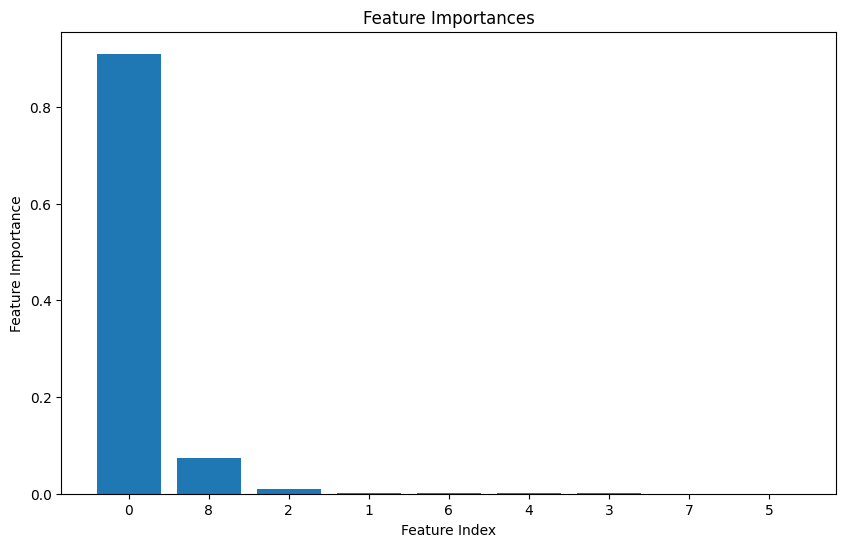

In [34]:

# Define features and target variables
X = df.drop(columns=['Solar_MW'])  # Features
y_solar = df['Solar_MW']  # Solar target variable

# Split the data into training and testing sets
X_train, X_test, y_solar_train, y_solar_test = train_test_split(
    X, y_solar, test_size=0.2, random_state=42)

# Initialize Gradient Boosting model
gbm_model = GradientBoostingRegressor()

# Fit the model
gbm_model.fit(X_train, y_solar_train)

# Get feature importances
importances = gbm_model.feature_importances_



# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.show()

In [35]:
# Define features and target variables
X = df.drop(columns=['Solar_MW'])  # Features
y_solar = df['Solar_MW']  # Solar target variable

# Split the data into training and testing sets
X_train, X_test, y_solar_train, y_solar_test = train_test_split(
    X, y_solar, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],  # Number of boosting stages
    'learning_rate': [0.01, 0.1],  # Learning rate (shrinkage)
    'max_depth': [3, 5],  # Maximum depth of the individual regression estimators
}

# Initialize GBM model
gbm_model = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(gbm_model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_solar_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters for Solar Power Production:", best_params)

Best Hyperparameters for Solar Power Production:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

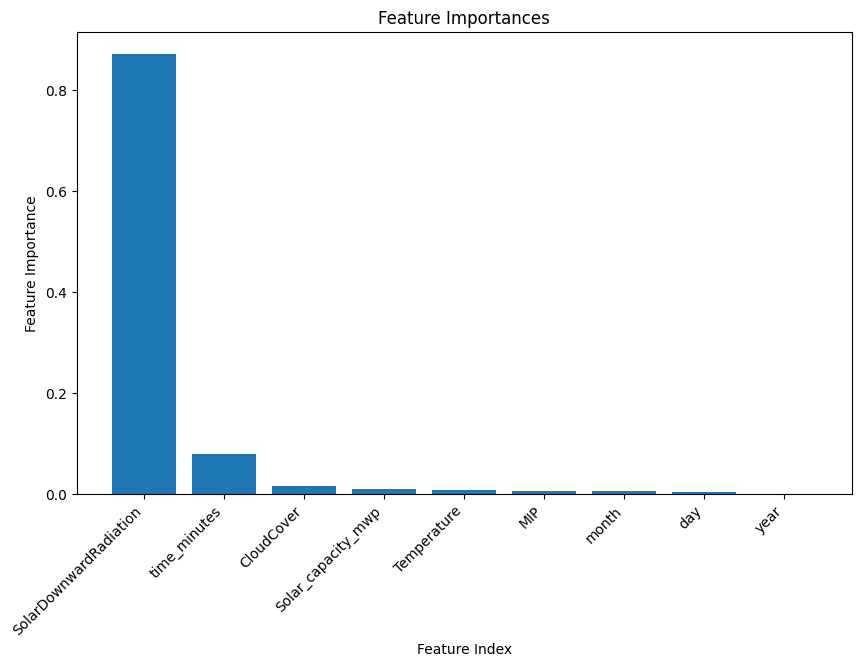

Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Mean Cross-Validation MSE: 218.26947609411528

Mean Cross-Validation Pinball Loss: 2.9310226442190093

In [36]:
# Initialize GBM model with the best hyperparameters
best_gbm_model = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42)

# Perform cross-validation
cv_results_mse = []
cv_results_pinball = []
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_solar_train.iloc[train_index], y_solar_train.iloc[val_index]
    
    # Fit the model on the training fold
    best_gbm_model.fit(X_train_fold, y_train_fold)
    
    # Evaluate the model on the validation fold
    y_pred_val = best_gbm_model.predict(X_val_fold)
    mse_val = mean_squared_error(y_val_fold, y_pred_val)
    cv_results_mse.append(mse_val)

    # Calculate Pinball Loss
    pinball_loss_val = mean_pinball_loss(y_pred_val, y_val_fold)
    cv_results_pinball.append(pinball_loss_val)

# Get feature importances
importances = best_gbm_model.feature_importances_


# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=45, ha="right")
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.show()

# Compute mean cross-validation MSE
mean_cv_mse = np.mean(cv_results_mse)
mean_cv_pinball = np.mean(cv_results_pinball)

print("Best Hyperparameters:", best_params)
print("Mean Cross-Validation MSE:", mean_cv_mse)
print("Mean Cross-Validation Pinball Loss:", mean_cv_pinball)

### RandomForestRegressor

In [40]:
# Define features and target variables
X = df.drop(columns=['Solar_MW'])  # Features
y_solar = df['Solar_MW']  # Solar target variable

# Split the data into training and testing sets
X_train, X_test, y_solar_train, y_solar_test = train_test_split(
    X, y_solar, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_solar_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
pinball_loss_solar1 = mean_pinball_loss(y_pred, y_solar_test, alpha=0.5)
print("Pinball Loss for Median Solar Power Production:", pinball_loss_solar1)
pinball_loss_solar2 = mean_pinball_loss(y_pred, y_solar_test, alpha=0.05)
print("Pinball Loss for Low Solar Power Production:", pinball_loss_solar2)
pinball_loss_solar3 = mean_pinball_loss(y_pred, y_solar_test, alpha=0.95)
print("Pinball Loss for High Solar Power Production:", pinball_loss_solar3)

Pinball Loss for Solar Power Production: 1.3685667610234005

Pinball Loss for Solar Power Production: 1.3545448130445943

Pinball Loss for Solar Power Production: 1.3825887090022069

## Linear Regression

In [41]:
# Define features and target variables
X = df.drop(columns=['Solar_MW'])  # Features
y_solar = df['Solar_MW']  # Solar target variable

# Split the data into training and testing sets
X_train, X_test, y_solar_train, y_solar_test = train_test_split(
    X, y_solar, test_size=0.2, random_state=42)

# Train separate linear regression models for Solar and Wind
solar_model = LinearRegression()
solar_model.fit(X_train, y_solar_train)

# Make predictions
y_solar_pred = solar_model.predict(X_test)

# Combine predictions

# Evaluate the combined prediction using Pinball Loss
pinball_loss_total1 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.5)
print("Pinball Loss for Median Solar Power Production:", pinball_loss_total1)
pinball_loss_total2 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.05)
print("Pinball Loss for Low Solar Power Production:", pinball_loss_total2)
pinball_loss_total3 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.95)
print("Pinball Loss for High Solar Power Production:", pinball_loss_total3)

Pinball Loss for Total Power Production: 7.057567704182342

Pinball Loss for Total Power Production: 7.0268728358983825

Pinball Loss for Total Power Production: 7.088262572466303

## ARIMA

In [39]:
# Load the dataset
df3 = pd.read_csv('energy_no_outliers_drop_.csv')

# Convert the 'dtm' column to datetime
df3['dtm'] = pd.to_datetime(df3['dtm'])

df3.head()
# Set 'dtm' as the index
df3.set_index('dtm', inplace=True)

# Resample the DataFrame to 30-minute intervals
df3 = df3.resample('30T').mean()

df3.head()

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# Specify the columns for forecasting
forecast_cols = ['Solar_MW']

# Train-test split
train = df3.loc[df3.index < '2022-01-01']
test = df3.loc[df3.index >= '2022-01-01']

# Iterate over the forecast columns
for col in forecast_cols:
    # Fit the ARIMA model
    model = ARIMA(train[col], order=(5,1,0))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    # Update the 'forecast' column in the test set
    test[col+'_forecast'] = forecast

# Drop rows with missing values
test.dropna(inplace=True)

# Calculate Pinball Loss for each forecast column
for col in forecast_cols:
    for alpha in [0.1, 0.5, 0.9]:
        loss = mean_pinball_loss(test[col], test[col+'_forecast'], alpha=alpha)
        print(f"Pinball Loss for {col} (alpha={alpha}): {loss}")



# Save or visualize the results as needed


NameError: name 'df3' is not defined